In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from itertools import groupby
%matplotlib inline

In [26]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00


## 1. Figure S2A

In [10]:
### functions ###

## calculate header length, but in this file, header was 0
def cal_header_len(code):
    header = 0
    with open(f"alignment/{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): header+=1
            else: continue
    return header
    

## read sam file using chunk
## also this does basic parsing
def read_sam_by_chunk(code, header=0, chunksize=10**5):
    df = pd.DataFrame()
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.iloc[:,3] = chunk.iloc[:,3].astype(int)
        chunk = chunk[(chunk.iloc[:,3]>48689480) & (chunk.iloc[:,3]<48689530)]
        if not chunk.empty: df = pd.concat([df,chunk])
        if cnt%10==0: print(cnt, end = ' ')
    return df


## parse dataframe more to analyze
def parse_df(df):
    df.columns = ['read', 'flag', 'chr', 'pos', 'map_qual', 'cigar', 'rnext', 'pnext', 'tlen', 'seq', 'qual',1,2,3,4]
    df_map = df[df['chr']=='chr13'][['pos','cigar','seq']]
    df_map = df_map[~df_map['cigar'].str.contains('S|I')]
    df_map.index = range(225)
    return df_map


## modify sequence using cigar string, add deletion as 'D'
def add_del(df_map):
    add_del_seq = []
    for row in df_map.itertuples():
        if row.cigar.find('D')==-1:
            add_del_seq.append(row.seq)
        else:
            flag = int(row.cigar[:2])
            add_del_seq.append(row.seq[:flag] + 'D' + row.seq[flag:])
        
    add_del_seq_df = pd.Series(add_del_seq)
    df_map = pd.concat([df_map, add_del_seq_df], axis=1)
    df_map = df_map.drop(labels='seq',axis=1)
    df_map.columns = ['pos', 'cigar', 'seq']
    return df_map
    
    
## calculate shannon entropy
def shannon(seq, base):
    p = seq.count(base)/len(seq) 
    return 0 if (p==0 or p==1) else (-p*np.log2(p) -(1-p)*np.log2(1-p))

In [250]:
df_map = add_del(parse_df(read_sam_by_chunk("CLIP_35L33G")))
df_map

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 

,pos,cigar,seq
0,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
1,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...
2,48689489,39M1D23M,ATAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTG...
3,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCCTT
4,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCGTT
...,...,...,...
220,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
221,48689515,78M,CGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCCTAAAACTATG...
222,48689490,62M,TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCTTTGTGG...
223,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...


In [237]:
pos_map = defaultdict(str)
for row in df_map.itertuples():
    for idx, base in enumerate(row.seq):
        pos_map[idx+row.pos]+=base

In [275]:
ref_seq = "TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCC"
x_axis = range(48689490,48689551)
y_axis = []
for idx, pos in enumerate(x_axis):
    y_axis.append(shannon(pos_map[pos],ref_seq[idx]))

Text(48689529, 1.1224491812352424, '0.9924')

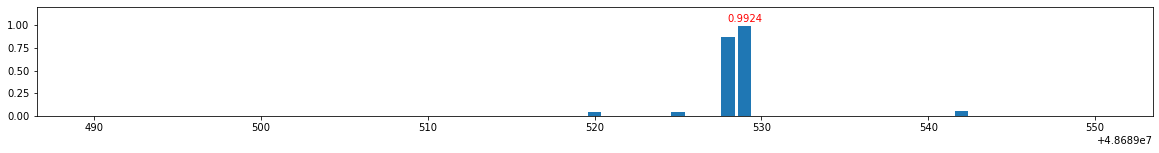

In [276]:
dic = { y:x for x, y in zip(x_axis, y_axis) }
plt.figure(figsize=(20,2))
plt.bar(x_axis,y_axis)
plt.ylim(0,1.2)
plt.text(dic[max(y_axis)],0.13+max(y_axis),
         str(round(max(y_axis),4)),
         color='r',
         horizontalalignment='center',
         verticalalignment='top')

## 2. Figure S2C, S2D

In [2]:
def fasta_iter(path):
    fh = open(path)
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        head = header.__next__()[1:].strip().split()[0]
        seq = "".join(s.strip() for s in faiter.__next__())
        yield head, seq
        
        
def read_sam_by_chunk2(code, header=0, chunksize=10**5):
    df = pd.DataFrame()
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.columns=['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','TLEN','SEQ','QUAL',1,2,3,4]
        chunk = chunk[(chunk['FLAG']!=4) & (chunk['FLAG']!=16) & (chunk['FLAG']!=272) & (chunk['FLAG']!=260)][['RNAME','POS','CIGAR','SEQ']]
        #chunk = chunk[~chunk['CIGAR'].str.contains('S')]
        if not chunk.empty: df = pd.concat([df,chunk])
        df = df.drop_duplicates(subset=['SEQ'])
        if cnt%10==0: print(cnt, end = ' ')
    return df


def parse_cigar(cigar):
    cigar_map = []
    tmp = ''
    D, I = 0, 0
    for i in cigar:
        if i.isnumeric(): tmp+=i
        else: 
            cigar_map.append((i,int(tmp)))
            if i == 'D': D+=int(tmp)
            elif i =='I': I+=int(tmp)
            tmp = ''
            
    return cigar_map, D, I


In [3]:
CLIP_df = read_sam_by_chunk2("CLIP_35L33G")
CLIP_df

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 

,RNAME,POS,CIGAR,SEQ
2,ENSMUST00000058679.7|ENSMUSG00000035078.7|OTTM...,2116,35M,ATGGCCTTCTAAGCACTGCAAGGTGGCAGTCACTC
4,ENSMUST00000103186.11|ENSMUSG00000047126.18|OT...,2876,28M,ATGAGGGCTGTGAGGAGCCTGCTACTCA
6,chr4,98626410,9S69M,CTACAGTCCGACGATCACGTCTCTGTCTTGAAGGGTGGACGGCTGA...
8,ENSMUST00000064762.6|ENSMUSG00000052727.7|OTTM...,1856,22M,AGTGACAGAAAAGGAGGTGTCC
12,ENSMUST00000044260.11|ENSMUSG00000033364.14|OT...,2319,27M,GGAAGATGTGGAAAAAGATTTGAAATT
...,...,...,...,...
81495970,chr9,70466321,47M,AAAAAACAAGAAGCGGATGAGTTGAGTAGAGATGCTTCTGTGGAAGA
81496029,ENSMUST00000058889.5|ENSMUSG00000055884.9|OTTM...,2324,40M,ATGAAAATGATAGAAGGAATGAGACACGAAGAGGGCGAAT
81496047,ENSMUST00000056889.15|ENSMUSG00000063870.13|OT...,2641,11S67M,ATCGGTGAAATTCCATAAGGAGGGCCACTCCAAAGGCCCCTTCTTC...
81496121,chr9,119260313,46M,TGCTGAAGAGCGACCTCACCACGGTGCTGGCTGACTTCGGCCTGGC


In [33]:
CLIP_df.to_csv('CLIP_df.csv',sep ='\t')

In [4]:
# "ref_gene/GRCm39.primary_assembly.genome.fa"
# "ref_gene/gencode.vM29.transcripts.fa"
trans_dict = {ff[0] : ff[1] for ff in fasta_iter("ref_gene/gencode.vM29.transcripts.fa")}
gene_dict = {ff[0] : ff[1] for ff in fasta_iter("ref_gene/GRCm39.primary_assembly.genome.fa")}

In [28]:
sub_map = [[0 for _ in range(6)] for _ in range(20)]
D_map = [[0 for _ in range(4)] for _ in range(20)]
I_map = [[0 for _ in range(4)] for _ in range(20)]
smap = {'A':0, 'T':1, 'G':2, 'C':3}

for cnt, row in enumerate(tqdm(CLIP_df.itertuples())):
    if cnt%665000==0 : print(int(cnt/665000), end=' ')
    pos = int(row.POS)-1
    cur_pos = 0
    L = len(row.SEQ)
    cigar, D, I = parse_cigar(row.CIGAR)
    refseq = trans_dict[row.RNAME] if row.RNAME.startswith("EN") else gene_dict[row.RNAME]

    for flag, cnt in cigar:
        if flag == 'N': pos+=cnt
        elif flag == 'S': cur_pos+=cnt
        
        elif flag == 'D':  
            sub_map[int(cur_pos/L*20)][4]+=cnt
            while cnt:
                D_map[int(cur_pos/L*20)][smap[refseq[pos]]]+=1
                pos+=1
                cnt-=1
                
        elif flag == 'I':
            sub_map[int(cur_pos/L*20)][5]+=cnt
            while cnt:
                I_map[int(cur_pos/L*20)][smap[refseq[pos]]]+=1
                cur_pos+=1
                cnt-=1
            
        else:  #'M'
            while cnt:
                if row.SEQ[cur_pos] != refseq[pos]: sub_map[int(cur_pos/L*20)][smap[refseq[pos]]]+=1 
                cur_pos+=1
                pos+=1
                cnt-=1
                
sub_df = pd.DataFrame(sub_map)
D_df = pd.DataFrame(D_map)
I_df = pd.DataFrame(I_map)
sub_df.columns = list(smap.keys()) + ['D','I']
sub_df['sub'] = sub_df['A'] + sub_df['T'] + sub_df['G'] + sub_df['C']

sub_df

21844it [00:00, 109387.02it/s]

0 

685928it [00:06, 112694.37it/s]

1 

1343992it [00:11, 113140.66it/s]

2 

2015416it [00:17, 113264.62it/s]

3 

2672205it [00:23, 112276.46it/s]

4 

3345705it [00:29, 106707.09it/s]

5 

3712791it [00:33, 111067.63it/s]


,A,T,G,C,D,I,sub
0,1977,1864,6528,1953,0,0,12322
1,8802,10125,41190,8896,1,0,69013
2,8825,12693,57269,12193,616,24,90980
3,11947,15536,61664,11998,4615,131,101145
4,12518,14101,69705,12145,13838,274,108469
5,9474,14394,80056,13655,25441,830,117579
6,11007,14157,82583,12753,37730,558,120500
7,10912,13988,88470,11373,45865,846,124743
8,11712,17188,103632,12921,53871,794,145453
9,10938,17406,82182,10839,44072,665,121365


In [29]:
total = sum([len(row.SEQ) for row in CLIP_df.itertuples()])

In [30]:
sub_df['pSub'], sub_df['pD'], sub_df['pI'] = sub_df['sub']/total*100*20, sub_df['D']/total*100*20, sub_df['I']/total*100*20
sub_df['pA'], sub_df['pT'], sub_df['pG'], sub_df['pC'] = sub_df['A']/total*100*20*4, sub_df['T']/total*100*20*4, sub_df['G']/total*100*20*4, sub_df['C']/total*100*20*4
sub_df

,A,T,G,C,D,I,sub,pSub,pD,pI,pA,pT,pG,pC
0,1977,1864,6528,1953,0,0,12322,0.179095,0.000000,0.000000,0.114940,0.108370,0.379528,0.113544
1,8802,10125,41190,8896,1,0,69013,1.003077,0.000015,0.000000,0.511734,0.588652,2.394722,0.517200
2,8825,12693,57269,12193,616,24,90980,1.322359,0.008953,0.000349,0.513072,0.737951,3.329530,0.708882
3,11947,15536,61664,11998,4615,131,101145,1.470103,0.067077,0.001904,0.694580,0.903239,3.585048,0.697545
4,12518,14101,69705,12145,13838,274,108469,1.576554,0.201130,0.003982,0.727777,0.819810,4.052540,0.706091
5,9474,14394,80056,13655,25441,830,117579,1.708965,0.369775,0.012064,0.550804,0.836845,4.654330,0.793880
6,11007,14157,82583,12753,37730,558,120500,1.751420,0.548391,0.008110,0.639930,0.823066,4.801246,0.741439
7,10912,13988,88470,11373,45865,846,124743,1.813091,0.666630,0.012296,0.634407,0.813240,5.143507,0.661208
8,11712,17188,103632,12921,53871,794,145453,2.114102,0.782994,0.011540,0.680917,0.999283,6.025002,0.751207
9,10938,17406,82182,10839,44072,665,121365,1.763993,0.640569,0.009666,0.635918,1.011958,4.777933,0.630162


In [49]:
D_df

,0,1,2,3
0,0,0,0,0
1,0,1,0,0
2,69,159,258,130
3,725,1063,2133,694
4,2473,3138,6247,1980
5,4611,5830,11520,3480
6,6798,8608,17333,4991
7,8102,10403,21586,5774
8,9776,12020,25153,6922
9,8284,9802,20298,5688


In [54]:
D_df['pA'], D_df['pT'], D_df['pG'], D_df['pC'] = D_df[0]/total*100*20*4, D_df[1]/total*100*20*4, D_df[2]/total*100*20*4, D_df[3]/total*100*20*4
I_df['pA'], I_df['pT'], I_df['pG'], I_df['pC'] = I_df[0]/total*100*20*4, I_df[1]/total*100*20*4, I_df[2]/total*100*20*4, I_df[3]/total*100*20*4

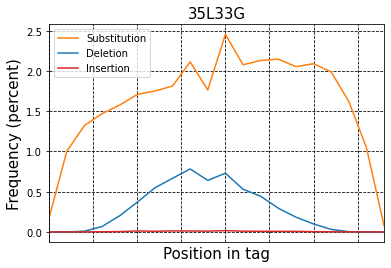

In [31]:
plt.title("35L33G", fontsize=15)
plt.plot(sub_df['pSub'] , 'C1', label='Substitution')
plt.plot(sub_df['pD'], 'C0', label='Deletion')
plt.plot(sub_df['pI'], 'C3', label='Insertion')
plt.grid(linestyle = '--', color = 'black')
plt.xlim([0,19])
plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.show()

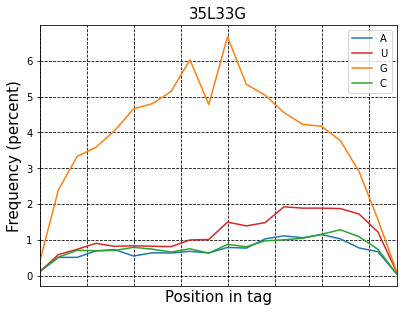

In [48]:
plt.title("35L33G", fontsize=15)
plt.grid(linestyle = '--', color = 'black')
plt.xlim([0,19])
plt.plot(sub_df['pA'], 'C0', label='A')
plt.plot(sub_df['pT'], 'C3', label='U')
plt.plot(sub_df['pG'], 'C1', label='G')
plt.plot(sub_df['pC'], 'C2', label='C')
plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.legend()
plt.show()

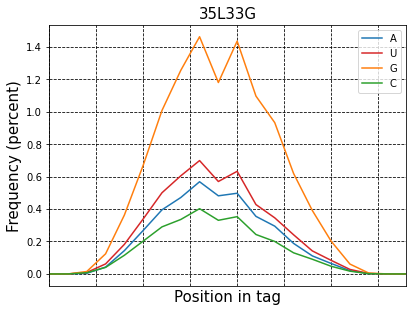

In [55]:
plt.title("35L33G", fontsize=15)
plt.grid(linestyle = '--', color = 'black')
plt.xlim([0,19])
plt.plot(D_df['pA'], 'C0', label='A')
plt.plot(D_df['pT'], 'C3', label='U')
plt.plot(D_df['pG'], 'C1', label='G')
plt.plot(D_df['pC'], 'C2', label='C')
plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.show()

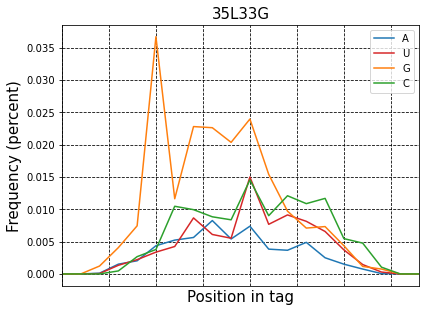

In [56]:
plt.title("35L33G", fontsize=15)
plt.grid(linestyle = '--', color = 'black')
plt.xlim([0,19])
plt.plot(I_df['pA'], 'C0', label='A')
plt.plot(I_df['pT'], 'C3', label='U')
plt.plot(I_df['pG'], 'C1', label='G')
plt.plot(I_df['pC'], 'C2', label='C')
plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.show()

## 3. Figure S3C, Figure 2A

In [5]:
smap = {'A':0, 'T':1, 'G':2, 'C':3}
pos_map = defaultdict(lambda:[0,0]) # 0 : match, 1 : mismatch

for cnt, row in enumerate(tqdm(CLIP_df.itertuples())):
    if cnt%665000==0 : print(int(cnt/665000), end=' ')
    pos = int(row.POS)-1
    cur_pos = 0
    L = len(row.SEQ)
    cigar, D, I = parse_cigar(row.CIGAR)
    refseq = trans_dict[row.RNAME] if row.RNAME.startswith("EN") else gene_dict[row.RNAME]

    for flag, cnt in cigar:
        if flag == 'N': pos+=cnt
        elif flag == 'I' or flag == 'S': cur_pos+=cnt
        
        elif flag == 'D':  
            while cnt:
                pos_map[row.RNAME[:20] +'/'+ str(pos)][1] += 1
                pos+=1
                cnt-=1
            
        else:  #'M'
            while cnt:
                if row.SEQ[cur_pos] == refseq[pos]: pos_map[row.RNAME[:20] +'/'+ str(pos)][0] += 1  
                else: pos_map[row.RNAME[:20] +'/'+ str(pos)][1] += 1
                cur_pos+=1
                pos+=1
                cnt-=1

2328it [00:00, 23276.25it/s]

0 

669467it [00:25, 29830.58it/s]

1 

1334923it [00:49, 31838.34it/s]

2 

2000150it [01:12, 33314.33it/s]

3 

2665558it [01:34, 33317.93it/s]

4 

3330393it [01:57, 31824.99it/s]

5 

3712791it [02:10, 28488.21it/s]


In [6]:
for i in pos_map :
    p = pos_map[i][0] / (pos_map[i][0] + pos_map[i][1])
    pos_map[i].append(0 if (p==0 or p==1) else (-p*np.log2(p) -(1-p)*np.log2(1-p)))

In [10]:
pos_map = {k: v for k, v in pos_map.items() if v[2]>=0.8 and v[0]+v[1] >= 30}
print(len(pos_map))

6449


In [28]:
pos_map2 = []
for row in list(pos_map.keys()):
    pos_map2.append(row.split('/'))

In [39]:
seq_list = []
for ref, pos in pos_map2:
    refseq = trans_dict[ref] if ref.startswith("EN") else gene_dict[ref]
    pos = int(pos)
    seq_list.append(refseq[pos-10:pos+11])

In [24]:
#Write Fasta file using print in for loop
with open('35L33G.fa','w') as outfile:
	for name, sequence in zip([v[0] for v in pos_map2], seq_list):
		print('>{}'.format(name), file = outfile) #name
		print(sequence, file = outfile) #sequence

In [41]:
with open('35L33G2.fa','w') as outfile:
	for sequence in seq_list:
		print(sequence, file = outfile) #sequence

In [43]:
seq_list_m = []
for ref, pos in pos_map2:
    refseq = trans_dict[ref] if ref.startswith("EN") else gene_dict[ref]
    pos = int(pos)
    seq_list_m.append(refseq[pos-5:pos+6])

with open('35L33G3.fa','w') as outfile:
	for sequence in seq_list_m:
		print(sequence, file = outfile) #sequence  

# 4. Figure 2B, 2D

In [59]:
hex_list = []
for ref, pos in pos_map2:
    refseq = trans_dict[ref] if ref.startswith("EN") else gene_dict[ref]
    pos = int(pos)
    target = refseq[pos-2:pos+4]
    target = target.replace('T','U')
    hex_list.append(target)
    
hex_df = pd.DataFrame(hex_list)
hex_df.columns = ['Sequences']
hex_df['Frequency (%)'] = 1/6449*100
hex_df.groupby(by=['Sequences']).sum().sort_values(by=['Frequency (%)'], ascending=False).head(10)

,Frequency (%)
Sequences,
AAGGAG,3.597457
GAGGAG,1.984804
AAGAAG,1.705691
AAGAGG,1.643666
AAGGUG,1.504109
AAGAGA,1.287021
GAGAAG,1.054427
CAGAGG,0.868352
AAGUGG,0.821833


In [60]:
flank_list = []
for ref, pos in pos_map2:
    refseq = trans_dict[ref] if ref.startswith("EN") else gene_dict[ref]
    pos = int(pos)
    target = refseq[pos-4:pos-2]+"......"+refseq[pos+4:pos+6] 
    target = target.replace('T','U')
    flank_list.append(target)

flank_df = pd.DataFrame(flank_list)
flank_df.columns = ['Sequences']
flank_df['Frequency (%)'] = 1/6449*100
flank_df.groupby(by=['Sequences']).sum().sort_values(by=['Frequency (%)'], ascending=False).head(10)

,Frequency (%)
Sequences,
CC......GG,2.481005
CA......UG,2.093348
GG......CC,1.938285
AG......CU,1.628159
GC......GC,1.581641
UC......GA,1.271515
GA......UG,1.162971
AC......GU,1.085440
CU......AG,1.007908
